In [47]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
fig_width = (21-5)/2.54
import seaborn as sns
sns.set_context("paper")

import poissonlearning as pl

import storage
import plotting

plotting.setup(latex=True)

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
SAVE_PLOTS = True
NUM_PLOTTING_POINTS = 5000

### Convenience functions

In [49]:
def compute_errors(experiments):
    for experiment in experiments:
        solution = experiment["solution"]
        if solution is not None:
            z = solution["z"].to_numpy()

            reference_experiments = list(
                filter(
                    lambda x:
                        "seed" in x
                        and x["seed"] == experiment["seed"] 
                        and x["n"] == experiment["n"]
                        and x["bump"] == experiment["bump"]
                        and x["eps"] == experiment["eps"],
                    experiments
                )
            )
            reference = max(reference_experiments, key=lambda x: x["p"])["solution"]

            error_L1 = np.abs(z - reference["z"]).mean()
            experiment["error_L1"] = error_L1

In [50]:
experiments = storage.load_results(name="p_one_circle_joined", folder="../results")
compute_errors(experiments)

### Visualisation for various p

In [55]:
selected_experiments = list(
    filter(
        lambda x:
            "seed" in x
            and x["seed"] == 0 
            and x["n"] == 10000
            and x["bump"] == "dirac"
            and x["p"] in [4, 16, 60, 100],
        experiments
    )
)
selected_experiments.sort(key=lambda x: x["p"])

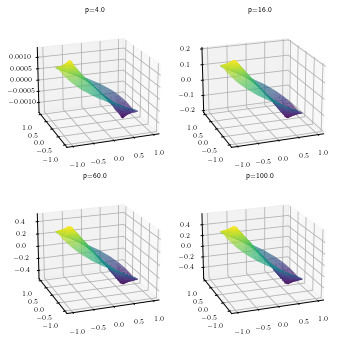

In [62]:
sample_size = NUM_PLOTTING_POINTS

sns.set_context("paper", font_scale=0.75)
fig_results = plt.figure(figsize=(0.75*fig_width, 0.75*fig_width))
for i, ex in enumerate(selected_experiments, start=1):
    ax_solution = fig_results.add_subplot(
        2,  # int(np.floor(np.sqrt(len(results[n])))),
        2,  # int(np.floor(np.sqrt(len(results[n])))),
        i,
        projection="3d",
    )

    sample = ex["solution"].sample(sample_size, random_state=1)
    xy = sample[["x", "y"]].to_numpy()

    dist = cdist(xy, xy, metric="euclidean",)
    plotting.plot_graph_function_with_triangulation(
        ax_solution, xy, sample["z"].to_numpy(), dist=dist, max_dist=0.1,
    )
    ax_solution.set_title(f"p={ex['p']}")
fig_results.tight_layout()

if SAVE_PLOTS:
    #fig_results.savefig(f"../plots/p_one_circle_surface_plot.pdf", bbox_inches="tight")
    fig_results.savefig(f"../plots/p_one_circle_surface_plot.png", bbox_inches="tight", dpi=300)

### Plot of error to largest p

In [63]:
n = 30000
selected_experiments = {
    n : list(
        filter(
            lambda x: 
                x["n"] == n
                and x["bump"] == "dirac",
            experiments
        )
    )
    for n in [10000, 20000, 30000]
}

p_error = list(set([e["p"] for e in list(selected_experiments.values())[0]]))
p_error = sorted(p_error)
p_max = max(p_error)
error = {bump: {} for bump in selected_experiments.keys()}
for bump, experiments_with_bump in selected_experiments.items():
    for p in p_error:
        if np.isclose(p, p_max):
            continue

        ex = list(filter(lambda x: np.isclose(x["p"], p), experiments_with_bump))
        error[bump][p] = {}
        error[bump][p]["mean"] = np.mean([e["error_L1"] for e in ex])
        error[bump][p]["max"] = np.max([e["error_L1"] for e in ex])
        error[bump][p]["min"] = np.min([e["error_L1"] for e in ex])
        print("Number of trials: ", len(ex))

Number of trials:  4
Number of trials:  4
Number of trials:  4
Number of trials:  4
Number of trials:  4
Number of trials:  4
Number of trials:  4
Number of trials:  4
Number of trials:  4
Number of trials:  4
Number of trials:  4
Number of trials:  4
Number of trials:  4
Number of trials:  4
Number of trials:  4
Number of trials:  4
Number of trials:  4
Number of trials:  4
Number of trials:  4
Number of trials:  4
Number of trials:  4
Number of trials:  3
Number of trials:  3
Number of trials:  3
Number of trials:  3
Number of trials:  3
Number of trials:  3
Number of trials:  3
Number of trials:  3
Number of trials:  3
Number of trials:  3
Number of trials:  3
Number of trials:  3
Number of trials:  3
Number of trials:  3
Number of trials:  3
Number of trials:  3
Number of trials:  3
Number of trials:  3
Number of trials:  3
Number of trials:  3
Number of trials:  3
Number of trials:  3
Number of trials:  3
Number of trials:  3
Number of trials:  3
Number of trials:  3
Number of tri

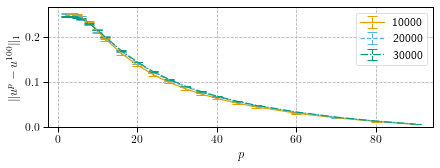

In [65]:
sns.set_context("paper", font_scale=4/3)
fig, ax = plt.subplots(1, 1, figsize=(fig_width, 0.4*fig_width))
ax.set_prop_cycle(plotting.line_cycler)

for i, (bump, e) in enumerate(error.items()):
    plotting.error_plot({bump: e}, ax)

ax.legend()
ax.set_xlabel(fr"$p$")
ax.set_ylabel(r"$\lVert u^p - u^{100} \rVert_1$")
ax.set_ylim(0.0, None)

fig.tight_layout()

if SAVE_PLOTS:
    fig.savefig(f"../plots/p_one_circle_error_largest_p.pdf", bbox_inches="tight")